# Bioinformatics - Assigment 1

## Jan Wyrzykowski

### Imports

In [ ]:
import numpy as np
import pandas as pd
import GEOparse
from scipy import stats
from Bio import Entrez, SeqIO, pairwise2
import biotite.sequence.io.fasta as fasta
from Bio.Blast import NCBIWWW, NCBIXML
from Bio.Align import substitution_matrices
from sklearn import preprocessing
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### 1. Data Retrieval

In [3]:
# Retrieve the dataset and change columns to distinguish between adenocarcinoma and squamous cell carcinoma 
gse_id = "GSE70970"
gse = GEOparse.get_GEO(geo=gse_id, destdir=".", silent=True)
sample_names = list(map(lambda sample: sample[1].get_metadata_attribute("title"), gse.gsms.items()))
expr_table = gse.pivot_samples("VALUE")
expr_df = expr_table.select_dtypes(include=[np.number])
expr_df = expr_df.fillna(0)
expr_df.columns = sample_names

# # Finding diferentially expressed genes with t-test
pvals = []
for g in expr_df.index:
    a = expr_df.loc[g, expr_df.columns.str.contains('Normal')].values
    b = expr_df.loc[g, expr_df.columns.str.contains('NPC')].values
    t, p = stats.ttest_ind(a, b, equal_var=False)
    pvals.append(p if not np.isnan(p) else 1.0)

pvals = np.array(pvals)

# Sorting genes by p-value ascending
genes_pvals = pd.DataFrame({'gene': expr_df.index, 'pval': pvals}).set_index("gene").sort_values('pval')
gene_names = genes_pvals.index
gene_name = "hsa-miR-1290"

expr_df.loc[gene_name].describe()

count    263.000000
mean       5.061568
std        2.895280
min        0.000000
25%        3.374111
50%        5.662465
75%        7.320721
max       11.206853
Name: hsa-miR-1290, dtype: float64

This dataset focuses on finding differences in gene expressions caused by Nasopharyngeal Carcinoma. It consists of 263 samples, each of 734 genes. I have chosen gene hsa-miR-1290 because of its low p-value in the test conducted above, as well as its presence in the NCBI database. Its expression across all samples ranges from 0 to 11.21, averages at 5.06 and has standard deviation equal to 2.90.

### 2. Sequence Extraction

In [13]:
Entrez.email = "01180912@pw.edu.pl"

# Search for a gene in NCBI database
handle = Entrez.esearch(db="nucleotide", term=f"{gene_name}[Gene] AND Homo Sapiens[Organism]", retmax=1)
record = Entrez.read(handle)
handle.close()

# Fetch the gene from the database
gene_id = record["IdList"][0]
handle = Entrez.efetch(db="nucleotide", id=gene_id, rettype="fasta")

# Write the sequence to a FASTA file
with open("nucl_seq.fasta", "w") as f:
    for r in SeqIO.parse(handle, "fasta"):
        SeqIO.write(r, f, "fasta")

### 3. Translation to Protein

In [ ]:
fasta_file = fasta.FastaFile.read("nucl_seq.fasta")
key = list(fasta_file.keys())[0]
nucl_sequence = fasta.get_sequence(fasta_file, key)

prot_sequence = nucl_sequence.translate(complete=True)
prot_seq_file = fasta.FastaFile()
prot_seq_file[key] = str(prot_sequence)

prot_seq_file.write("prot_seq.fasta")

NC_060925.1 Homo sapiens isolate CHM13 chromosome 1, alternate assembly T2T-CHM13v2.0


Once `prot_seq.fasta` is generated, you can use it to get the sequence instead of translating it again:

In [92]:
fasta_file_prot = fasta.FastaFile.read("prot_seq.fasta")
prot_sequence = fasta.get_sequence(fasta_file_prot)

### 4. Functional Annotation via BLAST

In [15]:
# I have decided to take first 100000 aminoacids of the protein sequence since the full sequence is tens of millions of characters long and the limit on query size is 100000
result_handle = NCBIWWW.qblast('blastp', 'swissprot', str(prot_sequence)[:100000])
blast_record = NCBIXML.read(result_handle)

hit_ids = []
descriptions = []
evalues = []
bit_scores = []
identities = []
query_coverage = []

for i, alignment in enumerate(blast_record.alignments):
    for hsp in alignment.hsps[:1]:  # Take first HSP for each alignment
        hit_ids.append(alignment.hit_id)
        descriptions.append(alignment.hit_def[:100] + "..." if len(alignment.hit_def) > 100 else alignment.hit_def)
        evalues.append(hsp.expect)
        bit_scores.append(hsp.score)
        identities.append(hsp.identities / hsp.align_length * 100 if hsp.align_length > 0 else 0)
        query_coverage.append(hsp.query_end - hsp.query_start + 1)

print(f"Hit amount: {len(hit_ids)}")

# Show top 10 hits in detail
print(f'\n=== Top 10 Hits Details ===')
for i in range(min(10, len(hit_ids))):
    print(f'Hit {i+1}: {hit_ids[i]}')
    print(f'  Identity: {identities[i]:.1f}%')
    print(f'  E-value: {evalues[i]:.2e}')
    print(f'  Description: {descriptions[i]}')
    print()

Hit amount: 35

=== Top 10 Hits Details ===
Hit 1: sp|P0C7U9.1|
  Identity: 92.4%
  E-value: 3.30e-94
  Description: RecName: Full=Protein FAM87A [Homo sapiens]

Hit 2: sp|O00370.1|
  Identity: 69.0%
  E-value: 1.08e-61
  Description: RecName: Full=LINE-1 retrotransposable element ORF2 protein; Short=ORF2p; Includes: RecName: Full=Re...

Hit 3: sp|Q06852.2|
  Identity: 33.0%
  E-value: 9.01e-41
  Description: RecName: Full=Cell surface glycoprotein 1; AltName: Full=Outer layer protein B; AltName: Full=S-laye...

Hit 4: sp|P08548.1|
  Identity: 50.5%
  E-value: 3.93e-38
  Description: RecName: Full=LINE-1 reverse transcriptase homolog [Nycticebus coucang]

Hit 5: sp|P11369.2|
  Identity: 47.3%
  E-value: 2.28e-36
  Description: RecName: Full=LINE-1 retrotransposable element ORF2 protein; Short=ORF2p; AltName: Full=Long intersp...

Hit 6: sp|Q9NX94.2|
  Identity: 77.4%
  E-value: 3.19e-36
  Description: RecName: Full=WW domain binding protein 1-like; AltName: Full=Outcome predictor in ac

Summary of inferred proteins (acquired from running above code with protein sequence of length 5000) based on NCBI protein database:
| Protein name | Description | Summary |
| - | - | - |
| Q06852.2 | Cell surface glycoprotein 1 | A protein found on cell walls of bacteria Acetivibrio thermocellus. It may be involved in attachment of the cellulosome to the cell surface. |
| Q9JKS4.1 | LIM domain-binding protein 3 | A protein found in Mus Musculus (house mouse). LIM domain-binding proteins are crucial in limb, nervous system, and muscle development. |
| Q99109.1 | Repellent protein 1 | Found in fungus Mycosarcoma maydis. It has hydrophobic properties and takes part in forming aerial hyphae. |
| P19597.2 | Circumsporozoite protein | Present in malaria parasite Plasmodium falciparum; used in malaria vaccine research. |
| P05691.1 | Circumsporozoite protein | Also present in Plasmodium falciparum; also used in vaccine research. |
| P13814.1 | Circumsporozoite protein | Present in Plasmodium falciparum found in Thailand; also used in vaccine research. |
| O75112.2 | LIM domain-binding protein 3 | Found in humans. From NCBI: "May function as an adapter in striated muscle to couple protein kinase C-mediated signaling via its LIM domains to the cytoskeleton." |
| P02893.1 | Circumsporozoite protein | Found in Plasmodium falciparum, used in vaccine research. |
| Q5KSL6.1 | Diacylglycerol kinase kappa | A protein found in humans. NCBI: "Diacylglycerol kinase that converts diacylglycerol/DAG into phosphatidic acid/phosphatidate/PA and regulates the respective levels of these two bioactive lipids". |
| A3DC27.1 | Anti-sigma-I factor RsgI2 [Acetivibrio thermocellus ATCC 27405] | Present in bacteria Acetivibrio thermocellus. Its task is to regulate SigI2 activity. |

### 5. Sequence Alignment and Substitution Matrices

I have decided to select proteins 1, 3 and 9 for variety. I am using BLOSUM, because my goal is to find local alignments - after all, protein sequences found with BLAST are much shorter than the original protein sequence.

In [9]:
protein_names = ["Q06852.2", "Q99109.1", "Q5KSL6.1"]

blosum62 = substitution_matrices.load("BLOSUM62")

for name in protein_names:
    handle = Entrez.esearch(db="protein", term=f"{name}[Version]", retmax=1)
    record = Entrez.read(handle)
    handle.close()

    gene_id = record["IdList"][0]
    handle = Entrez.efetch(db="protein", id=gene_id, rettype="fasta")

    records = SeqIO.parse(handle, "fasta")
    r = next(records)

    aligns = pairwise2.align.localds(str(prot_sequence)[:100000], r.seq, blosum62, -10, -0.5)
    print(f"\n\nPairwise alignment for protein {name}:\n")
    print(pairwise2.format_alignment(*aligns[0]))




Pairwise alignment for protein Q06852.2:

 294 P*PSPSPSPSPSPSPSPSPSPSPSPSPS-----PSPSPSPSPSPSPSPSPSPSPSPSPSPSPSPSPSPSPS-----P*P*P*P*P*P*P*P*P*P*P*P*P*P*P*P*P*P*P*P*P*-P*P*P*P*P*P*P*P*P*P*P*P*P*P*P*P*P*P*P*P*P*P*P*P*P*P*P*QP*P*P*P*P*P*P*P*P*P*P*P*P*P*P*P*P*P*P*P*P*P*P*P*P*P*P*P*PLTLTLTLTLTLTLP*P*P*P*P*P*P*P*PLTLNPNPNPNPNPNPTPT-------PTPTPTPNPTPTPTPTPTPTPTPTLTLTLTLTLTLTQP*P*P*P*P*P*P*PPNPNPNPNPNPNPNPNPNPNPNPNPNPNP*P*P*P*P*P*P*-P*PLTLTLTLTLTLTLTLNPNPN--PNPNPNPTLTLTLTLTLT-----LTLNPNPNPNPNPNPNPNPNPNP*P*P*P*PDPDP-----DPDPDPGP*P*P*P*P*P*P*P*P*P*P*P*P*P*PNPTLTLTLTLTLTLTLTLTLTLTPNPNPNPNPNPNP*P*PLN-PNPNPNPNPNPNPNPTLTLTLTLTLTLTLTPNPNP*P*P*P*P*P*PLTLTLTLTLTLTLTPNPNP*P*P*P*P*P*PL----------TLTLTLTLTLTLTLSAGAEARRAGAG
     |.||..|.||..|.||..|.||..|.||     |.|...||..|.||..|.||..|.||..|.||..|.||     |.|...|...|.|...|.|...|.|...|.|...|.|...|. |.|...|...|.|...|.|...|.|...|.|...|.|...|.|...|.|...|..|.|...|...|.|...|.|...|.|...|.|...|.|...|.|...|.|         ..|.........|...|.|...|.|...|   .|...|.|...|||.   

We can see that matched sequences greatly differ in size. Interestingly, every hit matched with similar parts of the original sequence, containing many P and S aminoacids.

All three parts of the sequence that were matched look kind of suspicious (with an exception at the end of the first sequence). It seems that the beginning of the nucleotide sequence of this gene just looks like that. It is possible that it is an intron and thus does not actually contribute to protein creation.

### 6. Dimensionality Reduction of Alignment Scores

Unfortunately the BLAST algorithm returned only 35 hits (with the longest aminoacid sequence length possible as an input, so I am not able to find more). This excercise is done with these 35 proteins.

In [30]:
all_protein_names = list(map(lambda x: x[3:-1], hit_ids))

all_protein_sequences = []

for name in all_protein_names:
    handle = Entrez.esearch(db="protein", term=f"{name}[Version]", retmax=1)
    record = Entrez.read(handle)
    handle.close()

    gene_id = record["IdList"][0]
    handle = Entrez.efetch(db="protein", id=gene_id, rettype="fasta")

    records = SeqIO.parse(handle, "fasta")
    all_protein_sequences.append(str(next(records).seq))

n = len(all_protein_sequences)

alignment_matrix = [[0 for __ in range(n)] for _ in range(n)]
blosum62 = substitution_matrices.load("BLOSUM62")

for i in range(n):
    for j in range(i, n):
        alignment_ij = pairwise2.align.localds(all_protein_sequences[i], all_protein_sequences[j], blosum62, -10, -0.5)
        alignment_matrix[i][j] = alignment_ij[0].score
        alignment_matrix[j][i] = alignment_ij[0].score


I have decided to go with PCA, because it's the first step in finding patterns in multidimensional data. It also showed clusters, which is a good sign!

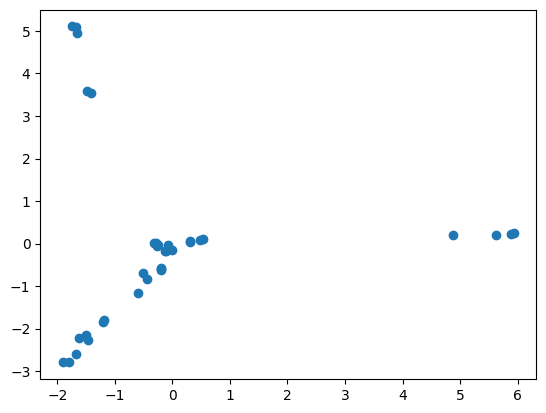

In [91]:
scaler = preprocessing.StandardScaler()
am_scaled = pd.DataFrame(scaler.fit_transform(alignment_matrix))

pca = PCA(n_components=2)
am_pca = pca.fit_transform(am_scaled)
plt.scatter(am_pca[:, 0], am_pca[:, 1]);

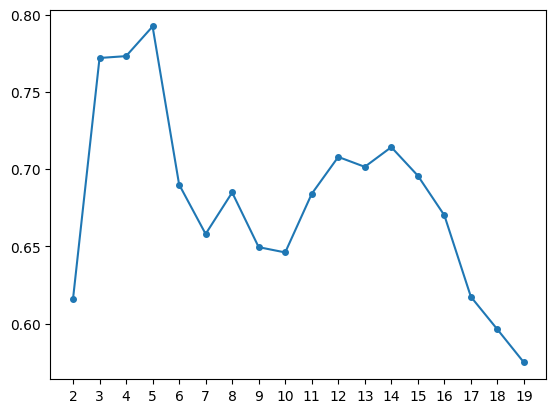

In [89]:
silhouette_scores = []

for i in range(2, 20):
    kmeans = KMeans(n_clusters=i)
    am_kmeans = kmeans.fit_predict(am_pca)
    silhouette_scores.append(silhouette_score(am_pca, am_kmeans))

plt.plot(silhouette_scores, marker="o", markersize=4, linestyle="solid")
plt.xticks(range(0, 18), range(2, 20));

This plot suggests that 3-5 clusters is the optimal amount. Below is the plot with 5 clusters:

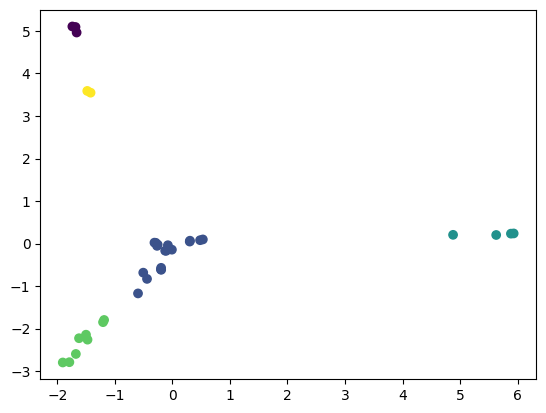

In [90]:
kmeans = KMeans(n_clusters=5)
cluster_labels = kmeans.fit_predict(am_pca)
plt.scatter(am_pca[:, 0], am_pca[:, 1], c=cluster_labels);